In [8]:
import pandas as pd
import numpy as np
import os
import sys
import re
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC
from matplotlib_venn import venn2
from matplotlib_venn import venn3
from linage import get_lineage_coll
from resistance import get_resistance_snp

In [9]:
def import_VCF4_to_pandas(vcf_file, sep='\t'):
    with open(vcf_file) as f:
        first_line = f.readline().strip()
    if first_line.endswith('VCFv4.0'):
        #Use first line as header
        dataframe = pd.read_csv(vcf_file, sep=sep, skiprows=[16], header=16)
        dataframe[['DP', 'AF', 'SB', 'DP4']] = dataframe['INFO'].str.split(r';.{1,3}=', expand=True)
        dataframe.DP = dataframe.DP.str.split('=').str[1]
        """
        DF4 = Number of :
        1) forward ref alleles; 
        2) reverse ref; 
        3) forward non-ref; 
        4) reverse non-ref alleles, used in variant calling. 
        Sum can be smaller than DP because low-quality bases are not counted.
        """
        dataframe[['Fref', 'Rref', 'Fsample', 'Rsample']] = dataframe['DP4'].str.split(',', expand=True)
        dataframe[['DP', 'AF', 'SB','Fref', 'Rref', 'Fsample', 'Rsample']] = dataframe[['DP', 'AF', 'SB','Fref', 'Rref', 'Fsample', 'Rsample']].astype(float)
    return dataframe

def replace_nucleotide(list_fasta, postition, nucleotide):
    list_fasta[postition] = nucleotide

#def replace_fasta_sequence(fasta, Nref, Nalt, position)


def replace_fasta_sequence(fasta, Nref_list, Nalt_list, position):
    
    fasta_to_replace = SeqIO.read(fasta,"fasta")
    sequence_to_replace = fasta_to_replace.seq
    sequence_list = list(sequence_to_replace)
    
    for index in range (len(position)):

        nucleotide_list = ['A','T','C','G']
        
        Nref = Nref_list[index]
        Nalt = Nalt_list[index]
    
        if Nref in nucleotide_list:
            nucleotide_list.remove(Nref)
        if Nalt in nucleotide_list:
            nucleotide_list.remove(Nalt)
        
        
        base_to_replace_with = nucleotide_list[0]

        
        sequence_list[position[index] - 1] = base_to_replace_with
        
    return "".join(sequence_list)
    #print(record_to_chop.seq[0:4])
    
def import_to_pandas(file_table, header=False, sep='\t'):
    if header == False:
        #exclude first line, exclusive for vcf outputted by PipelineTB
        dataframe = pd.read_csv(file_table, sep=sep, skiprows=[0], header=None)
    else:
        #Use first line as header
        dataframe = pd.read_csv(file_table, sep=sep, header=0)
    
    return dataframe

# P50 - 17171479
# P80 - 17160843
# P90 - 17152627

In [10]:
vcf_P150 = 'test/17171479.vcf'
vcf_P180 = 'test/17160843.vcf'
vcf_P190 = 'test/17152627.vcf'


reference="data/MTB_ancestorII_reference.fas"

fasta_to_replace = SeqIO.read(reference,"fasta")

sample_name = "PAIR1_50_50"

P150_df = import_VCF4_to_pandas(vcf_P150)
P180_df = import_VCF4_to_pandas(vcf_P180)
P190_df = import_VCF4_to_pandas(vcf_P190)


new_reference_seq = replace_fasta_sequence(reference,P150_df['REF'],P150_df['ALT'],P150_df['POS'])
new_reference_id = "%s_%s" % (fasta_to_replace.id, sample_name)

Output_new_reference = "Ancestor_PAIR15050.fasta"

#Create seqIO object
new_reference = SeqRecord(Seq(new_reference_seq), id = new_reference_id, description = "")


with open(Output_new_reference, "w") as output_handle:
    SeqIO.write(new_reference, output_handle, "fasta")

In [11]:
print(fasta_to_replace.seq[0:41])

TTGACCGATGACCCCGGTTCAGGCTTCACCACAGTGTGGAA


In [12]:
print(new_reference_seq[0:41])

TTGACCGATGACCCCGGTTCAGGCTTCACCACAGTGTGGAA


In [13]:
P150_df.head(10)

#CHROM    POS ID REF ALT  QUAL FILTER  \
0  MTB_anc   2532  .   C   T   762   PASS   
1  MTB_anc   6140  .   G   T  1557   PASS   
2  MTB_anc   9143  .   C   T  3392   PASS   
3  MTB_anc  11370  .   C   T  1338   PASS   
4  MTB_anc  13460  .   G   A  3606   PASS   
5  MTB_anc  14251  .   G   A   880   PASS   
6  MTB_anc  14401  .   G   A  2683   PASS   
7  MTB_anc  15117  .   G   C  5013   PASS   
8  MTB_anc  17608  .   G   C  1059   PASS   
9  MTB_anc  23174  .   A   C  2877   PASS   

                                      INFO     DP        AF   SB          DP4  \
0      DP=24;AF=0.958333;SB=0;DP4=0,0,14,9   24.0  0.958333  0.0     0,0,14,9   
1  DP=112;AF=0.482143;SB=5;DP4=23,34,28,26  112.0  0.482143  5.0  23,34,28,26   
2    DP=100;AF=1.000000;SB=0;DP4=0,0,56,44  100.0  1.000000  0.0    0,0,56,44   
3  DP=126;AF=0.428571;SB=4;DP4=37,34,23,31  126.0  0.428571  4.0  37,34,23,31   
4    DP=105;AF=1.000000;SB=0;DP4=0,0,50,55  105.0  1.000000  0.0    0,0,50,55   
5   DP=79;AF=0.531646;SB=0;DP4=20,16,23,19   79.0  0.531646  0.0  20,16,23,19   
6     DP=89;AF=0.977528;SB=0;DP4=0,0,49,38   89.0  0.977528  0.0    0,0,49,38   
7    DP=140;AF=1.000000;SB=0;DP4=0,0,65,75  140.0  1.000000  0.0    0,0,65,75   
8   DP=87;AF=0.505747;SB=0;DP4=17,24,18,26   87.0  0.505747  0.0  17,24,18,26   
9     DP=83;AF=1.000000;SB=0;DP4=0,0,46,37   83.0  1.000000  0.0    0,0,46,37   

   Fref  Rref  Fsample  Rsample  
0   0.0   0.0     14.0      9.0  
1  23.0  34.0     28.0     26.0  
2   0.0   0.0     56.0     44.0  
3  37.0  34.0     23.0     31.0  
4   0.0   0.0     50.0     55.0  
5  20.0  16.0     23.0     19.0  
6   0.0   0.0     49.0     38.0  
7   0.0   0.0     65.0     75.0  
8  17.0  24.0     18.0     26.0  
9   0.0   0.0     46.0     37.0

In [14]:
P150_df.dtypes

#CHROM      object
POS          int64
ID          object
REF         object
ALT         object
QUAL         int64
FILTER      object
INFO        object
DP         float64
AF         float64
SB         float64
DP4         object
Fref       float64
Rref       float64
Fsample    float64
Rsample    float64
dtype: object

In [15]:
P150_df.head(5)

#CHROM    POS ID REF ALT  QUAL FILTER  \
0  MTB_anc   2532  .   C   T   762   PASS   
1  MTB_anc   6140  .   G   T  1557   PASS   
2  MTB_anc   9143  .   C   T  3392   PASS   
3  MTB_anc  11370  .   C   T  1338   PASS   
4  MTB_anc  13460  .   G   A  3606   PASS   

                                      INFO     DP        AF   SB          DP4  \
0      DP=24;AF=0.958333;SB=0;DP4=0,0,14,9   24.0  0.958333  0.0     0,0,14,9   
1  DP=112;AF=0.482143;SB=5;DP4=23,34,28,26  112.0  0.482143  5.0  23,34,28,26   
2    DP=100;AF=1.000000;SB=0;DP4=0,0,56,44  100.0  1.000000  0.0    0,0,56,44   
3  DP=126;AF=0.428571;SB=4;DP4=37,34,23,31  126.0  0.428571  4.0  37,34,23,31   
4    DP=105;AF=1.000000;SB=0;DP4=0,0,50,55  105.0  1.000000  0.0    0,0,50,55   

   Fref  Rref  Fsample  Rsample  
0   0.0   0.0     14.0      9.0  
1  23.0  34.0     28.0     26.0  
2   0.0   0.0     56.0     44.0  
3  37.0  34.0     23.0     31.0  
4   0.0   0.0     50.0     55.0

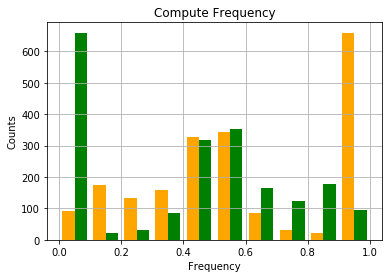

In [16]:
x = P150_df['AF']
reference = 1 - P150_df['AF']

plt.xlabel('Frequency')
plt.ylabel('Counts')
plt.title('Compute Frequency')
plt.grid(True)

plt.hist([x, reference], color=['orange', 'green']) 
plt.show()

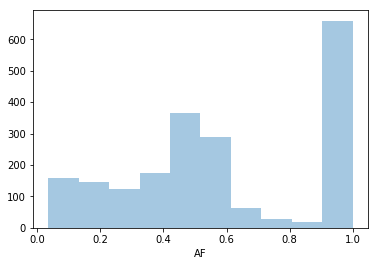

In [17]:
x = P150_df['AF']
espejo = 1 - P150_df['AF']

sns.distplot(x, kde=False, rug=False)
#sns.distplot(espejo, kde=False, rug=False)

In [18]:
P150_df['AF'].mean(axis = 0) 

0.5953203743209877

In [19]:
def scatter_vcf(vcf_df):
    y = vcf_df['AF'][vcf_df['AF'] < 1]
    x = vcf_df['AF'][vcf_df['AF'] < 1].index.values
    
    mean = vcf_df['AF'].mean(axis = 0)
    
    col_mean = np.where(vcf_df['AF'][vcf_df['AF'] < 1] > mean,'c','r')
    
    plt.figure(figsize=(50,20))
    plt.margins(x=0.01, y=0.01, tight=True)

    plt.xlabel('Frequency')
    plt.ylabel('Counts')
    plt.title('Compute Frequency')
    plt.grid(True)
    

    plt.scatter(x, y, color=col_mean, alpha=0.5, s=200) # colormap='jet'
    plt.show()
    

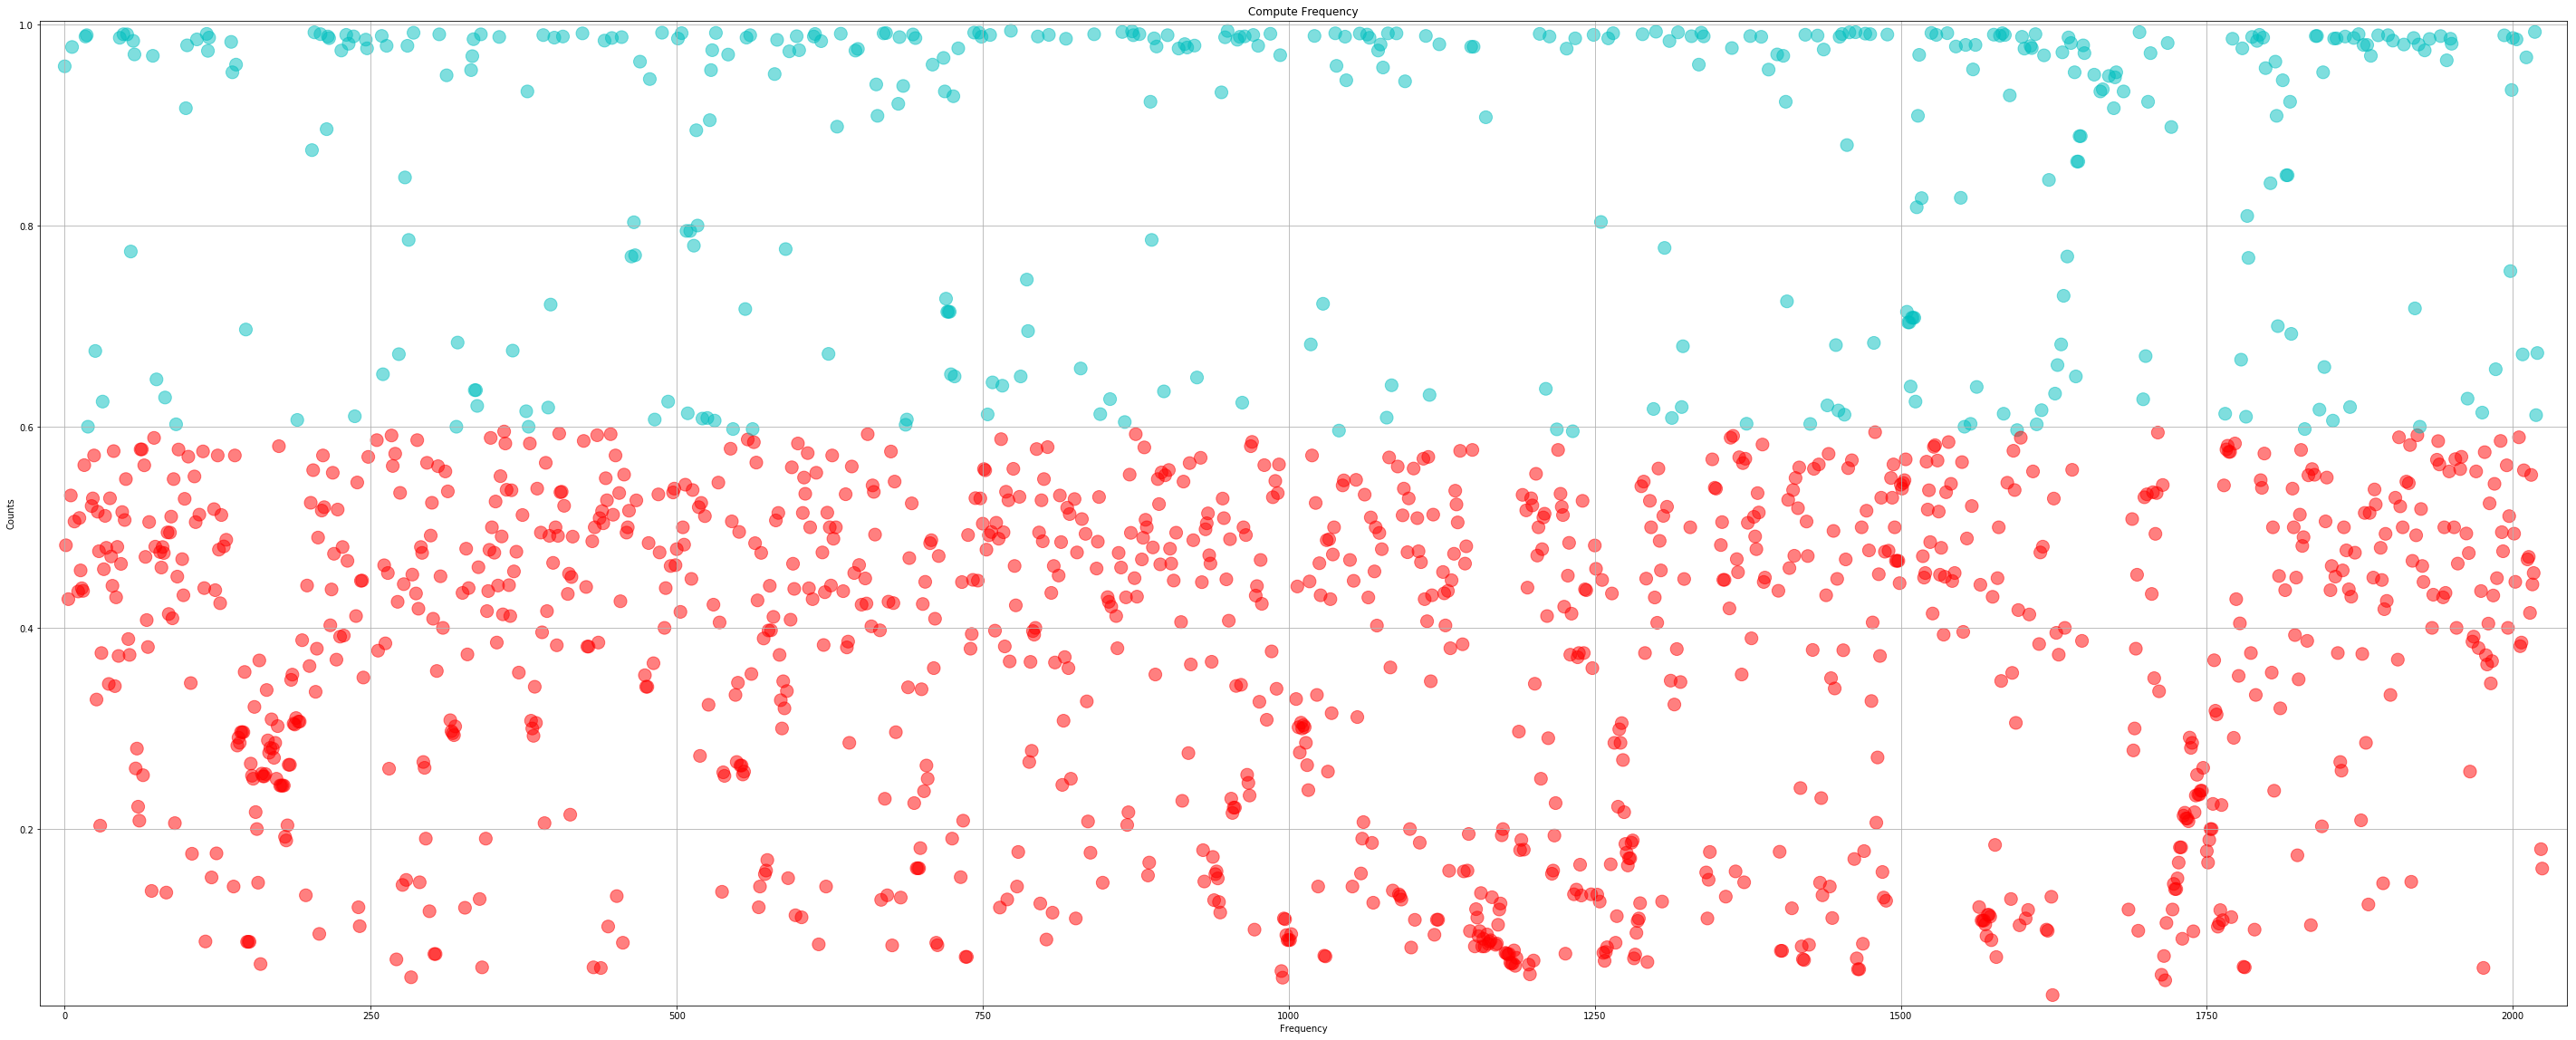

In [20]:
scatter_vcf(P150_df)

# FILTER REPEATS

In [21]:
list_positions = []
with open("data/repeats_annot.coords.tab") as f:
    for _ in range(1):
        next(f)
    for line in f:
        split_line = line.strip().split("\t")
        expression = "((row['POS'] >= %s) & (row['POS'] <= %s))" % (split_line[0], split_line[1])
        list_positions.append(expression)
print("(" + "|".join(list_positions) + ")")

(((row['POS'] >= 33582 ) & (row['POS'] <=  33794))|((row['POS'] >= 103710 ) & (row['POS'] <=  104663))|((row['POS'] >= 104805 ) & (row['POS'] <=  105215))|((row['POS'] >= 105324 ) & (row['POS'] <=  106715))|((row['POS'] >= 131382 ) & (row['POS'] <=  132872))|((row['POS'] >= 149533 ) & (row['POS'] <=  150996))|((row['POS'] >= 177543 ) & (row['POS'] <=  179309))|((row['POS'] >= 179319 ) & (row['POS'] <=  180896))|((row['POS'] >= 187433 ) & (row['POS'] <=  188839))|((row['POS'] >= 188931 ) & (row['POS'] <=  190439))|((row['POS'] >= 307877 ) & (row['POS'] <=  309547))|((row['POS'] >= 333437 ) & (row['POS'] <=  336310))|((row['POS'] >= 336560 ) & (row['POS'] <=  339073))|((row['POS'] >= 339364 ) & (row['POS'] <=  340974))|((row['POS'] >= 349624 ) & (row['POS'] <=  349932))|((row['POS'] >= 349935 ) & (row['POS'] <=  351476))|((row['POS'] >= 361334 ) & (row['POS'] <=  363109))|((row['POS'] >= 366150 ) & (row['POS'] <=  372764))|((row['POS'] >= 372820 ) & (row['POS'] <=  375711))|((row['POS'] 

In [22]:
def filter_repeats(row):
    if ((row['POS'] >= 33582 ) & (row['POS'] <=  33794))|((row['POS'] >= 103710 ) & (row['POS'] <=  104663))|((row['POS'] >= 104805 ) & (row['POS'] <=  105215))|((row['POS'] >= 105324 ) & (row['POS'] <=  106715))|((row['POS'] >= 131382 ) & (row['POS'] <=  132872))|((row['POS'] >= 149533 ) & (row['POS'] <=  150996))|((row['POS'] >= 177543 ) & (row['POS'] <=  179309))|((row['POS'] >= 179319 ) & (row['POS'] <=  180896))|((row['POS'] >= 187433 ) & (row['POS'] <=  188839))|((row['POS'] >= 188931 ) & (row['POS'] <=  190439))|((row['POS'] >= 307877 ) & (row['POS'] <=  309547))|((row['POS'] >= 333437 ) & (row['POS'] <=  336310))|((row['POS'] >= 336560 ) & (row['POS'] <=  339073))|((row['POS'] >= 339364 ) & (row['POS'] <=  340974))|((row['POS'] >= 349624 ) & (row['POS'] <=  349932))|((row['POS'] >= 349935 ) & (row['POS'] <=  351476))|((row['POS'] >= 361334 ) & (row['POS'] <=  363109))|((row['POS'] >= 366150 ) & (row['POS'] <=  372764))|((row['POS'] >= 372820 ) & (row['POS'] <=  375711))|((row['POS'] >= 399535 ) & (row['POS'] <=  400050))|((row['POS'] >= 400192 ) & (row['POS'] <=  401703))|((row['POS'] >= 424269 ) & (row['POS'] <=  424694))|((row['POS'] >= 424777 ) & (row['POS'] <=  434679))|((row['POS'] >= 466672 ) & (row['POS'] <=  467406))|((row['POS'] >= 467459 ) & (row['POS'] <=  468001))|((row['POS'] >= 472781 ) & (row['POS'] <=  474106))|((row['POS'] >= 475816 ) & (row['POS'] <=  476184))|((row['POS'] >= 530751 ) & (row['POS'] <=  532214))|((row['POS'] >= 543174 ) & (row['POS'] <=  544730))|((row['POS'] >= 606551 ) & (row['POS'] <=  608062))|((row['POS'] >= 622793 ) & (row['POS'] <=  624577))|((row['POS'] >= 671996 ) & (row['POS'] <=  675916))|((row['POS'] >= 832534 ) & (row['POS'] <=  832848))|((row['POS'] >= 832981 ) & (row['POS'] <=  833508))|((row['POS'] >= 835701 ) & (row['POS'] <=  838052))|((row['POS'] >= 838451 ) & (row['POS'] <=  840856))|((row['POS'] >= 846159 ) & (row['POS'] <=  847913))|((row['POS'] >= 848103 ) & (row['POS'] <=  850040))|((row['POS'] >= 850342 ) & (row['POS'] <=  850527))|((row['POS'] >= 889072 ) & (row['POS'] <=  889398))|((row['POS'] >= 889395 ) & (row['POS'] <=  890333))|((row['POS'] >= 890388 ) & (row['POS'] <=  891482))|((row['POS'] >= 924951 ) & (row['POS'] <=  925364))|((row['POS'] >= 925361 ) & (row['POS'] <=  927610))|((row['POS'] >= 927837 ) & (row['POS'] <=  930485))|((row['POS'] >= 947312 ) & (row['POS'] <=  947644))|((row['POS'] >= 968424 ) & (row['POS'] <=  970244))|((row['POS'] >= 976872 ) & (row['POS'] <=  978203))|((row['POS'] >= 1020058 ) & (row['POS'] <=  1021329))|((row['POS'] >= 1021344 ) & (row['POS'] <=  1021643))|((row['POS'] >= 1025497 ) & (row['POS'] <=  1026816))|((row['POS'] >= 1027104 ) & (row['POS'] <=  1027685))|((row['POS'] >= 1027685 ) & (row['POS'] <=  1029337))|((row['POS'] >= 1090373 ) & (row['POS'] <=  1093144))|((row['POS'] >= 1093361 ) & (row['POS'] <=  1094356))|((row['POS'] >= 1095078 ) & (row['POS'] <=  1096451))|((row['POS'] >= 1158918 ) & (row['POS'] <=  1159307))|((row['POS'] >= 1159375 ) & (row['POS'] <=  1160061))|((row['POS'] >= 1161297 ) & (row['POS'] <=  1162472))|((row['POS'] >= 1162549 ) & (row['POS'] <=  1163376))|((row['POS'] >= 1164572 ) & (row['POS'] <=  1165435))|((row['POS'] >= 1165092 ) & (row['POS'] <=  1165499))|((row['POS'] >= 1169423 ) & (row['POS'] <=  1170670))|((row['POS'] >= 1176928 ) & (row['POS'] <=  1177242))|((row['POS'] >= 1188421 ) & (row['POS'] <=  1190424))|((row['POS'] >= 1190757 ) & (row['POS'] <=  1192148))|((row['POS'] >= 1211560 ) & (row['POS'] <=  1213863))|((row['POS'] >= 1214513 ) & (row['POS'] <=  1214947))|((row['POS'] >= 1214769 ) & (row['POS'] <=  1215131))|((row['POS'] >= 1216469 ) & (row['POS'] <=  1219030))|((row['POS'] >= 1251617 ) & (row['POS'] <=  1252972))|((row['POS'] >= 1262272 ) & (row['POS'] <=  1264128))|((row['POS'] >= 1276300 ) & (row['POS'] <=  1277748))|((row['POS'] >= 1277893 ) & (row['POS'] <=  1278300))|((row['POS'] >= 1298764 ) & (row['POS'] <=  1299804))|((row['POS'] >= 1299822 ) & (row['POS'] <=  1300124))|((row['POS'] >= 1301755 ) & (row['POS'] <=  1302681))|((row['POS'] >= 1339003 ) & (row['POS'] <=  1339302))|((row['POS'] >= 1339349 ) & (row['POS'] <=  1340524))|((row['POS'] >= 1341358 ) & (row['POS'] <=  1342605))|((row['POS'] >= 1357293 ) & (row['POS'] <=  1357625))|((row['POS'] >= 1384989 ) & (row['POS'] <=  1386677))|((row['POS'] >= 1468171 ) & (row['POS'] <=  1469505))|((row['POS'] >= 1488154 ) & (row['POS'] <=  1489965))|((row['POS'] >= 1532443 ) & (row['POS'] <=  1533633))|((row['POS'] >= 1541994 ) & (row['POS'] <=  1542878))|((row['POS'] >= 1542929 ) & (row['POS'] <=  1543255))|((row['POS'] >= 1561464 ) & (row['POS'] <=  1561772))|((row['POS'] >= 1561769 ) & (row['POS'] <=  1563388))|((row['POS'] >= 1572127 ) & (row['POS'] <=  1573857))|((row['POS'] >= 1606386 ) & (row['POS'] <=  1607972))|((row['POS'] >= 1618209 ) & (row['POS'] <=  1619684))|((row['POS'] >= 1630638 ) & (row['POS'] <=  1634627))|((row['POS'] >= 1636004 ) & (row['POS'] <=  1638229))|((row['POS'] >= 1655609 ) & (row['POS'] <=  1656721))|((row['POS'] >= 1751297 ) & (row['POS'] <=  1753333))|((row['POS'] >= 1779194 ) & (row['POS'] <=  1779298))|((row['POS'] >= 1779314 ) & (row['POS'] <=  1779724))|((row['POS'] >= 1779930 ) & (row['POS'] <=  1780241))|((row['POS'] >= 1780199 ) & (row['POS'] <=  1780699))|((row['POS'] >= 1780643 ) & (row['POS'] <=  1782064))|((row['POS'] >= 1782072 ) & (row['POS'] <=  1782584))|((row['POS'] >= 1782758 ) & (row['POS'] <=  1783228))|((row['POS'] >= 1783309 ) & (row['POS'] <=  1783623))|((row['POS'] >= 1783620 ) & (row['POS'] <=  1783892))|((row['POS'] >= 1783906 ) & (row['POS'] <=  1784301))|((row['POS'] >= 1784497 ) & (row['POS'] <=  1785912))|((row['POS'] >= 1785912 ) & (row['POS'] <=  1786310))|((row['POS'] >= 1786307 ) & (row['POS'] <=  1786528))|((row['POS'] >= 1786584 ) & (row['POS'] <=  1787099))|((row['POS'] >= 1787096 ) & (row['POS'] <=  1788505))|((row['POS'] >= 1788162 ) & (row['POS'] <=  1789163))|((row['POS'] >= 1789168 ) & (row['POS'] <=  1789836))|((row['POS'] >= 1855764 ) & (row['POS'] <=  1856696))|((row['POS'] >= 1862347 ) & (row['POS'] <=  1865382))|((row['POS'] >= 1931497 ) & (row['POS'] <=  1932654))|((row['POS'] >= 1932694 ) & (row['POS'] <=  1933878))|((row['POS'] >= 1981614 ) & (row['POS'] <=  1984775))|((row['POS'] >= 1987745 ) & (row['POS'] <=  1988629))|((row['POS'] >= 1988680 ) & (row['POS'] <=  1989006))|((row['POS'] >= 1989833 ) & (row['POS'] <=  1992577))|((row['POS'] >= 1996152 ) & (row['POS'] <=  1996478))|((row['POS'] >= 1996529 ) & (row['POS'] <=  1997413))|((row['POS'] >= 1999142 ) & (row['POS'] <=  1999357)):
        return True
    elif ((row['POS'] >= 2000614 ) & (row['POS'] <=  2002470))|((row['POS'] >= 2025301 ) & (row['POS'] <=  2026398))|((row['POS'] >= 2026477 ) & (row['POS'] <=  2026776))|((row['POS'] >= 2026790 ) & (row['POS'] <=  2027971))|((row['POS'] >= 2028425 ) & (row['POS'] <=  2029477))|((row['POS'] >= 2029904 ) & (row['POS'] <=  2030203))|((row['POS'] >= 2039453 ) & (row['POS'] <=  2041420))|((row['POS'] >= 2042001 ) & (row['POS'] <=  2043272))|((row['POS'] >= 2043384 ) & (row['POS'] <=  2044775))|((row['POS'] >= 2044923 ) & (row['POS'] <=  2046842))|((row['POS'] >= 2048072 ) & (row['POS'] <=  2048371))|((row['POS'] >= 2048398 ) & (row['POS'] <=  2049597))|((row['POS'] >= 2049921 ) & (row['POS'] <=  2051150))|((row['POS'] >= 2051282 ) & (row['POS'] <=  2052688))|((row['POS'] >= 2061178 ) & (row['POS'] <=  2062674))|((row['POS'] >= 2087971 ) & (row['POS'] <=  2089518))|((row['POS'] >= 2162932 ) & (row['POS'] <=  2167311))|((row['POS'] >= 2167649 ) & (row['POS'] <=  2170612))|((row['POS'] >= 2195989 ) & (row['POS'] <=  2197353))|((row['POS'] >= 2226244 ) & (row['POS'] <=  2227920))|((row['POS'] >= 2260665 ) & (row['POS'] <=  2261144))|((row['POS'] >= 2261098 ) & (row['POS'] <=  2261688))|((row['POS'] >= 2358389 ) & (row['POS'] <=  2360041))|((row['POS'] >= 2365465 ) & (row['POS'] <=  2365791))|((row['POS'] >= 2365788 ) & (row['POS'] <=  2366726))|((row['POS'] >= 2367359 ) & (row['POS'] <=  2367655))|((row['POS'] >= 2367711 ) & (row['POS'] <=  2368442))|((row['POS'] >= 2381071 ) & (row['POS'] <=  2382492))|((row['POS'] >= 2387202 ) & (row['POS'] <=  2387972))|((row['POS'] >= 2423240 ) & (row['POS'] <=  2424838))|((row['POS'] >= 2430159 ) & (row['POS'] <=  2431199))|((row['POS'] >= 2431094 ) & (row['POS'] <=  2431420))|((row['POS'] >= 2439282 ) & (row['POS'] <=  2439947))|((row['POS'] >= 2550065 ) & (row['POS'] <=  2550391))|((row['POS'] >= 2550388 ) & (row['POS'] <=  2551326))|((row['POS'] >= 2600731 ) & (row['POS'] <=  2601879))|((row['POS'] >= 2617667 ) & (row['POS'] <=  2618908))|((row['POS'] >= 2632923 ) & (row['POS'] <=  2634098))|((row['POS'] >= 2634528 ) & (row['POS'] <=  2635592))|((row['POS'] >= 2635628 ) & (row['POS'] <=  2635954))|((row['POS'] >= 2635951 ) & (row['POS'] <=  2636889))|((row['POS'] >= 2637688 ) & (row['POS'] <=  2639535))|((row['POS'] >= 2651753 ) & (row['POS'] <=  2651938))|((row['POS'] >= 2692799 ) & (row['POS'] <=  2693884))|((row['POS'] >= 2706017 ) & (row['POS'] <=  2706736))|((row['POS'] >= 2720776 ) & (row['POS'] <=  2721777))|((row['POS'] >= 2727336 ) & (row['POS'] <=  2727920))|((row['POS'] >= 2727967 ) & (row['POS'] <=  2728266))|((row['POS'] >= 2784657 ) & (row['POS'] <=  2785697))|((row['POS'] >= 2785592 ) & (row['POS'] <=  2785918))|((row['POS'] >= 2795301 ) & (row['POS'] <=  2797385))|((row['POS'] >= 2801254 ) & (row['POS'] <=  2806236))|((row['POS'] >= 2828556 ) & (row['POS'] <=  2829803))|((row['POS'] >= 2835785 ) & (row['POS'] <=  2837263))|((row['POS'] >= 2921551 ) & (row['POS'] <=  2923182))|((row['POS'] >= 2935046 ) & (row['POS'] <=  2936788))|((row['POS'] >= 2943600 ) & (row['POS'] <=  2944985))|((row['POS'] >= 2960105 ) & (row['POS'] <=  2962441))|((row['POS'] >= 2970551 ) & (row['POS'] <=  2971549))|((row['POS'] >= 2972160 ) & (row['POS'] <=  2972486))|((row['POS'] >= 2972435 ) & (row['POS'] <=  2973421))|((row['POS'] >= 2973795 ) & (row['POS'] <=  2975234))|((row['POS'] >= 2975242 ) & (row['POS'] <=  2975775))|((row['POS'] >= 2975928 ) & (row['POS'] <=  2976554))|((row['POS'] >= 2976586 ) & (row['POS'] <=  2976909))|((row['POS'] >= 2976989 ) & (row['POS'] <=  2977234))|((row['POS'] >= 2977231 ) & (row['POS'] <=  2978658))|((row['POS'] >= 2978660 ) & (row['POS'] <=  2979052))|((row['POS'] >= 2979049 ) & (row['POS'] <=  2979309))|((row['POS'] >= 2979326 ) & (row['POS'] <=  2979688))|((row['POS'] >= 2979691 ) & (row['POS'] <=  2980818))|((row['POS'] >= 2983071 ) & (row['POS'] <=  2983874))|((row['POS'] >= 3053914 ) & (row['POS'] <=  3055491))|((row['POS'] >= 3076894 ) & (row['POS'] <=  3078078))|((row['POS'] >= 3078158 ) & (row['POS'] <=  3078985))|((row['POS'] >= 3079309 ) & (row['POS'] <=  3080457))|((row['POS'] >= 3100202 ) & (row['POS'] <=  3101581))|((row['POS'] >= 3115741 ) & (row['POS'] <=  3116142))|((row['POS'] >= 3116818 ) & (row['POS'] <=  3118227))|((row['POS'] >= 3120566 ) & (row['POS'] <=  3121504))|((row['POS'] >= 3121501 ) & (row['POS'] <=  3121827))|((row['POS'] >= 3162268 ) & (row['POS'] <=  3164115))|((row['POS'] >= 3194166 ) & (row['POS'] <=  3195548))|((row['POS'] >= 3200794 ) & (row['POS'] <=  3202020))|((row['POS'] >= 3288464 ) & (row['POS'] <=  3289705))|((row['POS'] >= 3289705 ) & (row['POS'] <=  3290235))|((row['POS'] >= 3289790 ) & (row['POS'] <=  3290506))|((row['POS'] >= 3313283 ) & (row['POS'] <=  3313672))|((row['POS'] >= 3333785 ) & (row['POS'] <=  3335164))|((row['POS'] >= 3376939 ) & (row['POS'] <=  3378243))|((row['POS'] >= 3378329 ) & (row['POS'] <=  3378415))|((row['POS'] >= 3379376 ) & (row['POS'] <=  3380452))|((row['POS'] >= 3380440 ) & (row['POS'] <=  3380682))|((row['POS'] >= 3380679 ) & (row['POS'] <=  3380993))|((row['POS'] >= 3381375 ) & (row['POS'] <=  3382622))|((row['POS'] >= 3465778 ) & (row['POS'] <=  3467091))|((row['POS'] >= 3481451 ) & (row['POS'] <=  3482698))|((row['POS'] >= 3490476 ) & (row['POS'] <=  3491651))|((row['POS'] >= 3501334 ) & (row['POS'] <=  3501732))|((row['POS'] >= 3501794 ) & (row['POS'] <=  3502936))|((row['POS'] >= 3510088 ) & (row['POS'] <=  3511317))|((row['POS'] >= 3527391 ) & (row['POS'] <=  3529163))|((row['POS'] >= 3551281 ) & (row['POS'] <=  3551607))|((row['POS'] >= 3551604 ) & (row['POS'] <=  3552542))|((row['POS'] >= 3552764 ) & (row['POS'] <=  3553090))|((row['POS'] >= 3553087 ) & (row['POS'] <=  3554025))|((row['POS'] >= 3557311 ) & (row['POS'] <=  3558345))|((row['POS'] >= 3710433 ) & (row['POS'] <=  3710759))|((row['POS'] >= 3710756 ) & (row['POS'] <=  3711694))|((row['POS'] >= 3711749 ) & (row['POS'] <=  3713461))|((row['POS'] >= 3729364 ) & (row['POS'] <=  3736935))|((row['POS'] >= 3736984 ) & (row['POS'] <=  3738438))|((row['POS'] >= 3738158 ) & (row['POS'] <=  3742774))|((row['POS'] >= 3743711 ) & (row['POS'] <=  3753184))|((row['POS'] >= 3753765 ) & (row['POS'] <=  3754256))|((row['POS'] >= 3754293 ) & (row['POS'] <=  3755033))|((row['POS'] >= 3755952 ) & (row['POS'] <=  3767102))|((row['POS'] >= 3778568 ) & (row['POS'] <=  3780334))|((row['POS'] >= 3795100 ) & (row['POS'] <=  3795984))|((row['POS'] >= 3796035 ) & (row['POS'] <=  3796361))|((row['POS'] >= 3800092 ) & (row['POS'] <=  3800796))|((row['POS'] >= 3800786 ) & (row['POS'] <=  3801463))|((row['POS'] >= 3801653 ) & (row['POS'] <=  3803848))|((row['POS'] >= 3842239 ) & (row['POS'] <=  3842769))|((row['POS'] >= 3843036 ) & (row['POS'] <=  3843734))|((row['POS'] >= 3843885 ) & (row['POS'] <=  3844640))|((row['POS'] >= 3844738 ) & (row['POS'] <=  3845970))|((row['POS'] >= 3847165 ) & (row['POS'] <=  3847701))|((row['POS'] >= 3883525 ) & (row['POS'] <=  3884193))|((row['POS'] >= 3883964 ) & (row['POS'] <=  3884917))|((row['POS'] >= 3890830 ) & (row['POS'] <=  3891156))|((row['POS'] >= 3891051 ) & (row['POS'] <=  3892091))|((row['POS'] >= 3894093 ) & (row['POS'] <=  3894389))|((row['POS'] >= 3894426 ) & (row['POS'] <=  3895607))|((row['POS'] >= 3926569 ) & (row['POS'] <=  3930714))|((row['POS'] >= 3931005 ) & (row['POS'] <=  3936710))|((row['POS'] >= 3939617 ) & (row['POS'] <=  3941761))|((row['POS'] >= 3941724 ) & (row['POS'] <=  3944963))|((row['POS'] >= 3945794 ) & (row['POS'] <=  3950263))|((row['POS'] >= 3969343 ) & (row['POS'] <=  3970563))|((row['POS'] >= 3970705 ) & (row['POS'] <=  3972453))|((row['POS'] >= 3978059 ) & (row['POS'] <=  3979498))|((row['POS'] >= 3997980 ) & (row['POS'] <=  3999638))|((row['POS'] >= 4031404 ) & (row['POS'] <=  4033158))|((row['POS'] >= 4036731 ) & (row['POS'] <=  4038050))|((row['POS'] >= 4060648 ) & (row['POS'] <=  4061889))|((row['POS'] >= 4061899 ) & (row['POS'] <=  4062198))|((row['POS'] >= 4075752 ) & (row['POS'] <=  4076099))|((row['POS'] >= 4076484 ) & (row['POS'] <=  4076984))|((row['POS'] >= 4076984 ) & (row['POS'] <=  4077730))|((row['POS'] >= 4091233 ) & (row['POS'] <=  4091517))|((row['POS'] >= 4093632 ) & (row['POS'] <=  4093946))|((row['POS'] >= 4093940 ) & (row['POS'] <=  4094527))|((row['POS'] >= 4189285 ) & (row['POS'] <=  4190232))|((row['POS'] >= 4190284 ) & (row['POS'] <=  4190517))|((row['POS'] >= 4196171 ) & (row['POS'] <=  4196506))|((row['POS'] >= 4198874 ) & (row['POS'] <=  4199089))|((row['POS'] >= 4252993 ) & (row['POS'] <=  4254327))|((row['POS'] >= 4276571 ) & (row['POS'] <=  4278085))|((row['POS'] >= 4301563 ) & (row['POS'] <=  4302789))|((row['POS'] >= 4318775 ) & (row['POS'] <=  4319266))|((row['POS'] >= 4350745 ) & (row['POS'] <=  4351044))|((row['POS'] >= 4351075 ) & (row['POS'] <=  4352181))|((row['POS'] >= 4374484 ) & (row['POS'] <=  4375683))|((row['POS'] >= 4375762 ) & (row['POS'] <=  4375995)):
        return True
    else:
        return False

In [23]:
P150_df.head()

#CHROM    POS ID REF ALT  QUAL FILTER  \
0  MTB_anc   2532  .   C   T   762   PASS   
1  MTB_anc   6140  .   G   T  1557   PASS   
2  MTB_anc   9143  .   C   T  3392   PASS   
3  MTB_anc  11370  .   C   T  1338   PASS   
4  MTB_anc  13460  .   G   A  3606   PASS   

                                      INFO     DP        AF   SB          DP4  \
0      DP=24;AF=0.958333;SB=0;DP4=0,0,14,9   24.0  0.958333  0.0     0,0,14,9   
1  DP=112;AF=0.482143;SB=5;DP4=23,34,28,26  112.0  0.482143  5.0  23,34,28,26   
2    DP=100;AF=1.000000;SB=0;DP4=0,0,56,44  100.0  1.000000  0.0    0,0,56,44   
3  DP=126;AF=0.428571;SB=4;DP4=37,34,23,31  126.0  0.428571  4.0  37,34,23,31   
4    DP=105;AF=1.000000;SB=0;DP4=0,0,50,55  105.0  1.000000  0.0    0,0,50,55   

   Fref  Rref  Fsample  Rsample  
0   0.0   0.0     14.0      9.0  
1  23.0  34.0     28.0     26.0  
2   0.0   0.0     56.0     44.0  
3  37.0  34.0     23.0     31.0  
4   0.0   0.0     50.0     55.0

## Apply repeat info

In [24]:
P150_df['Is_repeat'] = P150_df.apply(filter_repeats, axis=1)
P180_df['Is_repeat'] = P180_df.apply(filter_repeats, axis=1)
P190_df['Is_repeat'] = P190_df.apply(filter_repeats, axis=1)

In [25]:
P150_df_nr = P150_df[P150_df['Is_repeat'] == False].reset_index(drop=True)
P180_df_nr = P180_df[P180_df['Is_repeat'] == False].reset_index(drop=True)
P190_df_nr = P190_df[P190_df['Is_repeat'] == False].reset_index(drop=True)

In [26]:
def scatter_vcf_pos(vcf_df):
    y = vcf_df['AF'][vcf_df['AF'] < 1]
    x = vcf_df['POS'][vcf_df['AF'] < 1]
    plt.figure(figsize=(100,25))
    plt.margins(x=0.01, y=0.01, tight=True)
    
    mean = vcf_df['AF'][vcf_df['AF'] < 1].mean(axis = 0)
    
    col_mean = np.where(vcf_df['AF'][vcf_df['AF'] < 1] > mean,'c','salmon')

    plt.xlabel('Frequency')
    plt.ylabel('Counts')
    plt.title('Compute Frequency')
    
    # Turn on the minor TICKS, which are required for the minor GRID
    plt.minorticks_on()

    # Customize the major grid
    plt.grid(which='major', linestyle='-', linewidth='1', color='k')
    # Customize the minor grid
    plt.grid(which='minor', linestyle=':', linewidth='1', color='k')
    
    # Turn on/off the display of all ticks.
    plt.tick_params(which='minor', # Options for both major and minor ticks
                top='off', # turn off top ticks
                left='off', # turn off left ticks
                right='off',  # turn off right ticks
                bottom='on') # turn on bottom ticks
    plt.grid(True)

    plt.scatter(x, y, color=col_mean, alpha=0.5, s=300)
    plt.show()

/home/laura/env36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


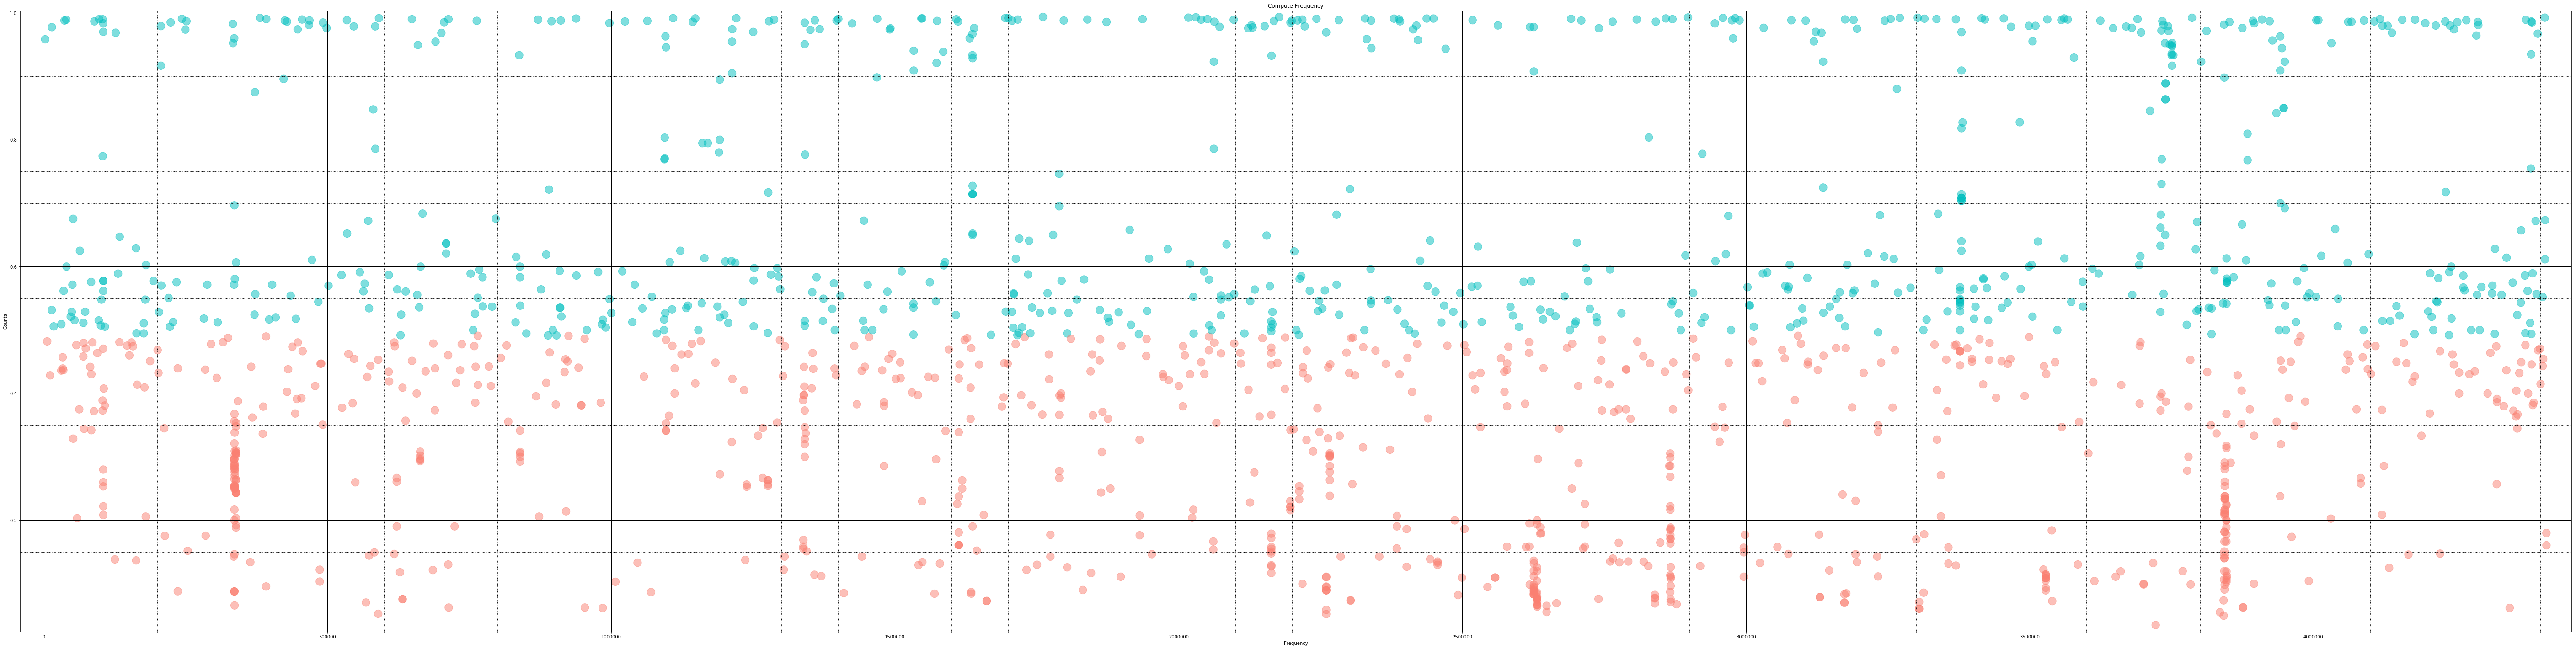

In [27]:
scatter_vcf_pos(P150_df)

In [28]:
P150_df.shape

(2025, 17)

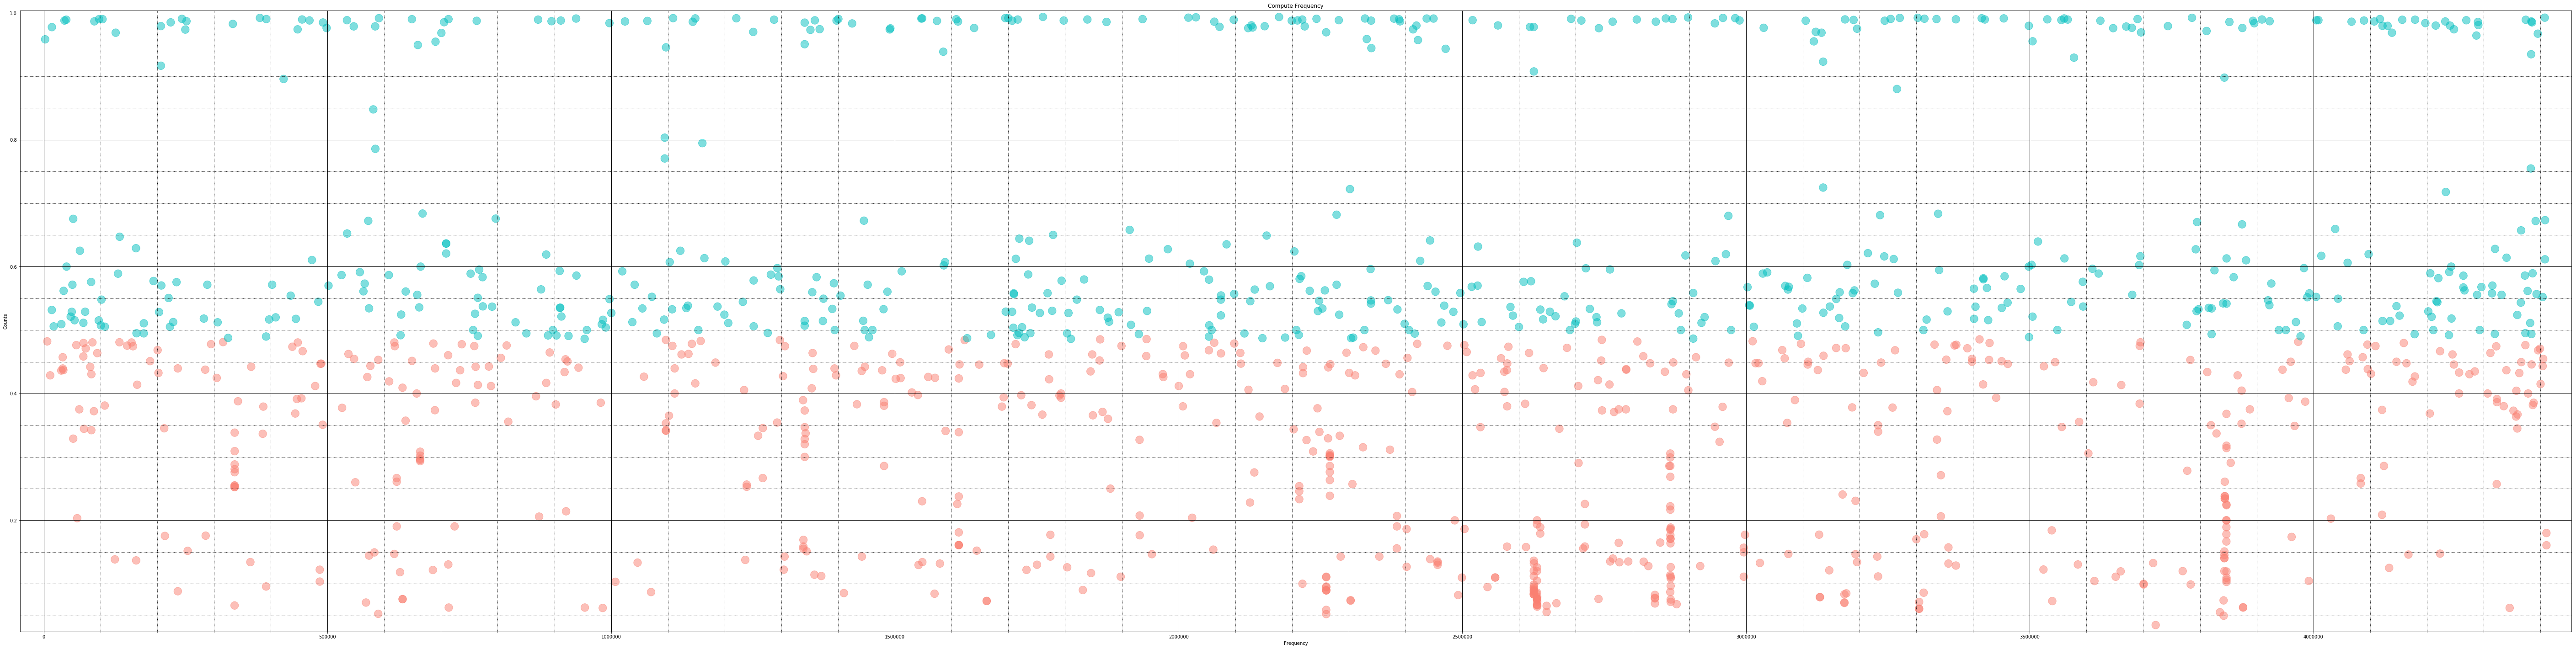

In [29]:
scatter_vcf_pos(P150_df_nr)

In [30]:
P150_df_nr.shape

(1579, 17)

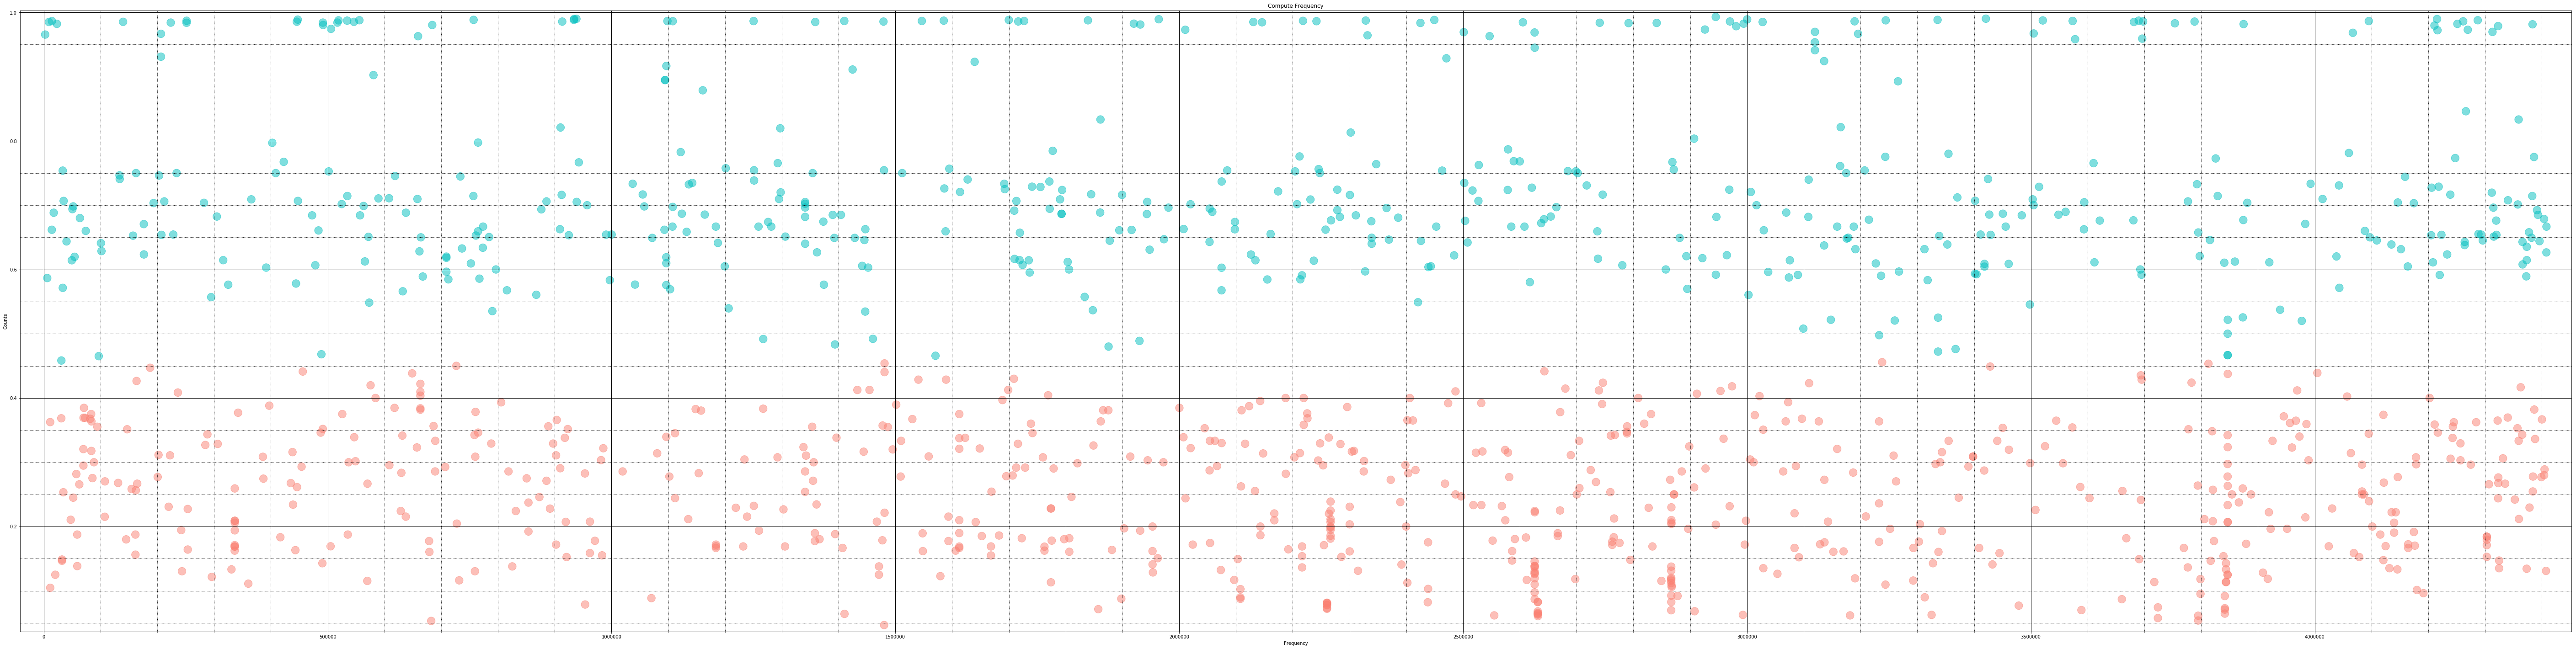

In [31]:
scatter_vcf_pos(P180_df_nr)

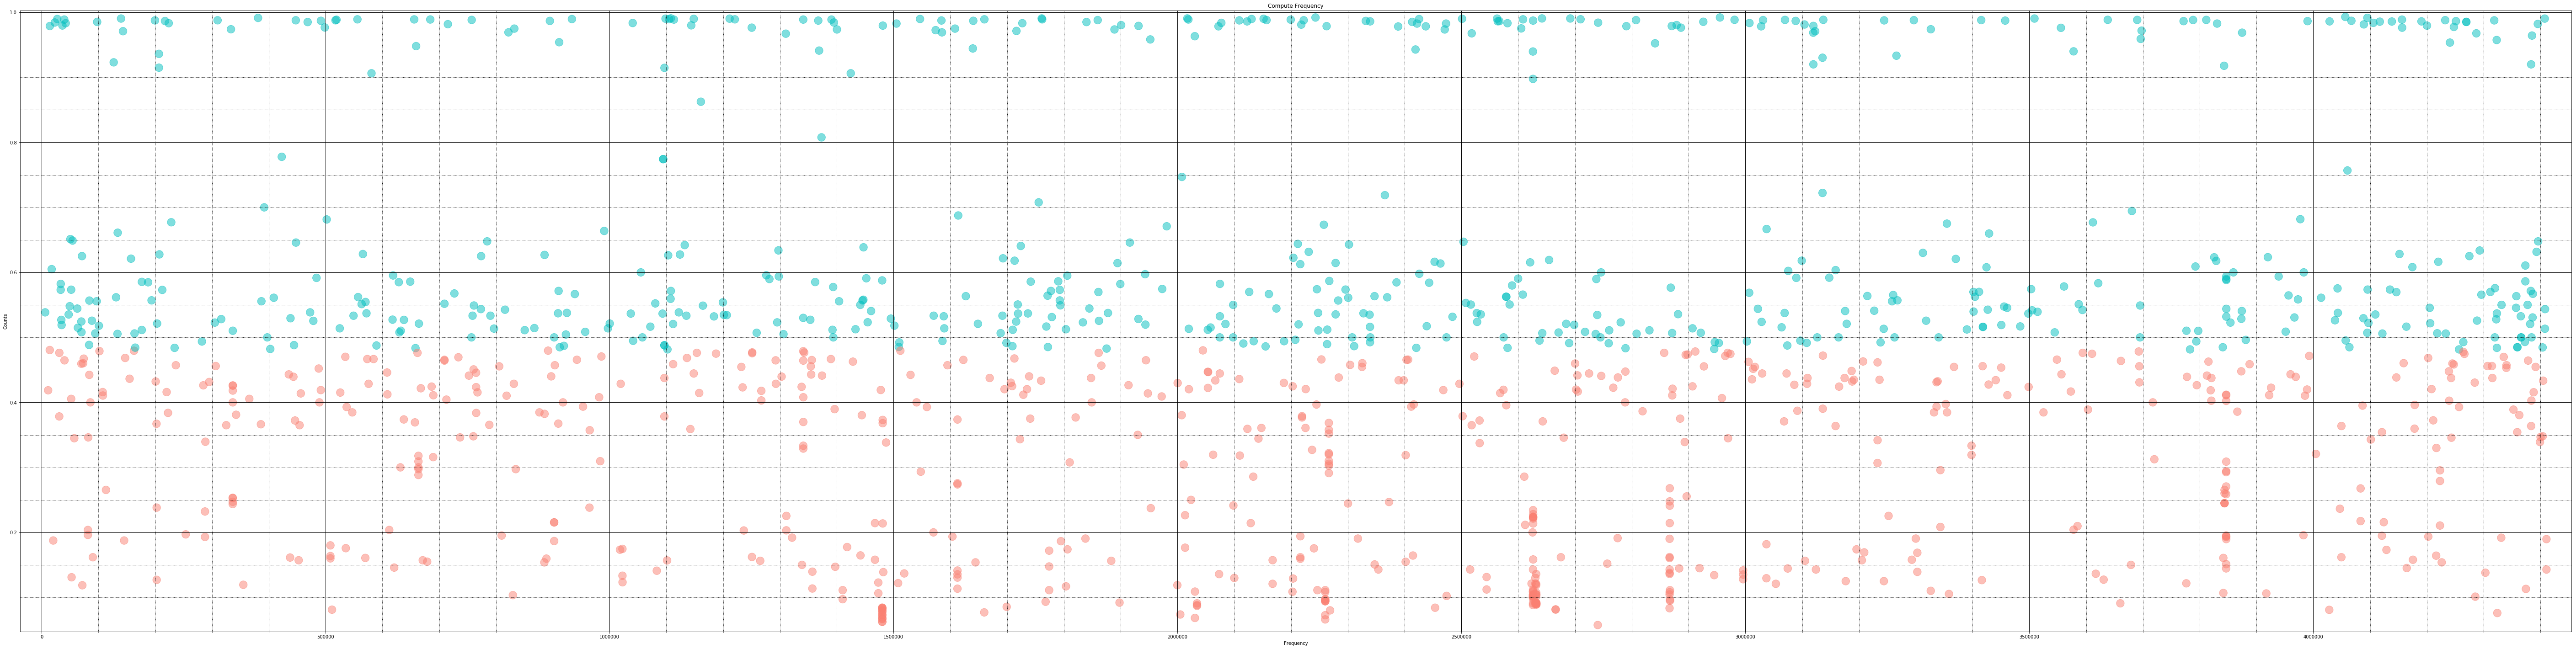

In [32]:
scatter_vcf_pos(P190_df_nr)

In [33]:
def create_bin(bin, max):
    for i in range(1, max, bin):
        print(i,i+bin-1)

In [34]:
print(len(P180_df_nr.index.values))

1599


In [35]:
print(P180_df_nr.loc[1002,'POS'])

2791098


In [36]:
def add_snp_distance(vcf_df):
    for index in vcf_df.index.values:
        if index > 0:
            vcf_df.loc[index,'snp_left_distance'] = vcf_df.loc[index,'POS'] - vcf_df.loc[index - 1,'POS']
        if index < (len(vcf_df.index.values) - 1):
            vcf_df.loc[index,'snp_right_distance'] = vcf_df.loc[index + 1,'POS'] - vcf_df.loc[index,'POS']
            
    return vcf_df

In [37]:
#P190_df_nr[P190_df_nr.isnull().any(axis=1)]

In [38]:
P190_df_nr_ds = add_snp_distance(P190_df_nr)
P180_df_nr_ds = add_snp_distance(P180_df_nr)
P150_df_nr_ds = add_snp_distance(P150_df_nr)

In [39]:
P180_df_nr_ds.tail()

#CHROM      POS ID REF ALT  QUAL FILTER  \
1594  MTB_anc  4407588  .   C   T  3529   PASS   
1595  MTB_anc  4407970  .   G   A  1491   PASS   
1596  MTB_anc  4408156  .   A   C  1695   PASS   
1597  MTB_anc  4408920  .   G   A  1959   PASS   
1598  MTB_anc  4408923  .   T   C  1984   PASS   

                                        INFO     DP        AF   SB  \
1594   DP=101;AF=1.000000;SB=0;DP4=0,0,49,52  101.0  1.000000  0.0   
1595  DP=83;AF=0.626506;SB=5;DP4=17,14,21,31   83.0  0.626506  5.0   
1596  DP=81;AF=0.666667;SB=0;DP4=12,15,23,31   81.0  0.666667  0.0   
1597    DP=57;AF=1.000000;SB=0;DP4=0,0,28,29   57.0  1.000000  0.0   
1598    DP=58;AF=1.000000;SB=0;DP4=0,0,29,29   58.0  1.000000  0.0   

              DP4  Fref  Rref  Fsample  Rsample  Is_repeat  \
1594    0,0,49,52   0.0   0.0     49.0     52.0      False   
1595  17,14,21,31  17.0  14.0     21.0     31.0      False   
1596  12,15,23,31  12.0  15.0     23.0     31.0      False   
1597    0,0,28,29   0.0   0.0     28.0     29.0      False   
1598    0,0,29,29   0.0   0.0     29.0     29.0      False   

      snp_right_distance  snp_left_distance  
1594               382.0              273.0  
1595               186.0              382.0  
1596               764.0              186.0  
1597                 3.0              764.0  
1598                 NaN                3.0

In [40]:
P180_df_nr_ds['snp_left_distance'].describe()

count     1598.000000
mean      2757.441176
std       3235.605728
min          0.000000
25%        481.500000
50%       1666.000000
75%       3823.250000
max      27856.000000
Name: snp_left_distance, dtype: float64

In [41]:
def filter_by_distance(vcf_dist_df, distance):
    vcf_df_filtered_distance = vcf_dist_df[((vcf_dist_df['snp_right_distance'] > distance) | (vcf_dist_df['snp_left_distance'] > distance))]
    return vcf_df_filtered_distance

In [42]:
PAIR190_dsf = filter_by_distance(P190_df_nr_ds, 1500)
PAIR180_dsf = filter_by_distance(P180_df_nr_ds, 1500)
PAIR150_dsf = filter_by_distance(P150_df_nr_ds, 1500)

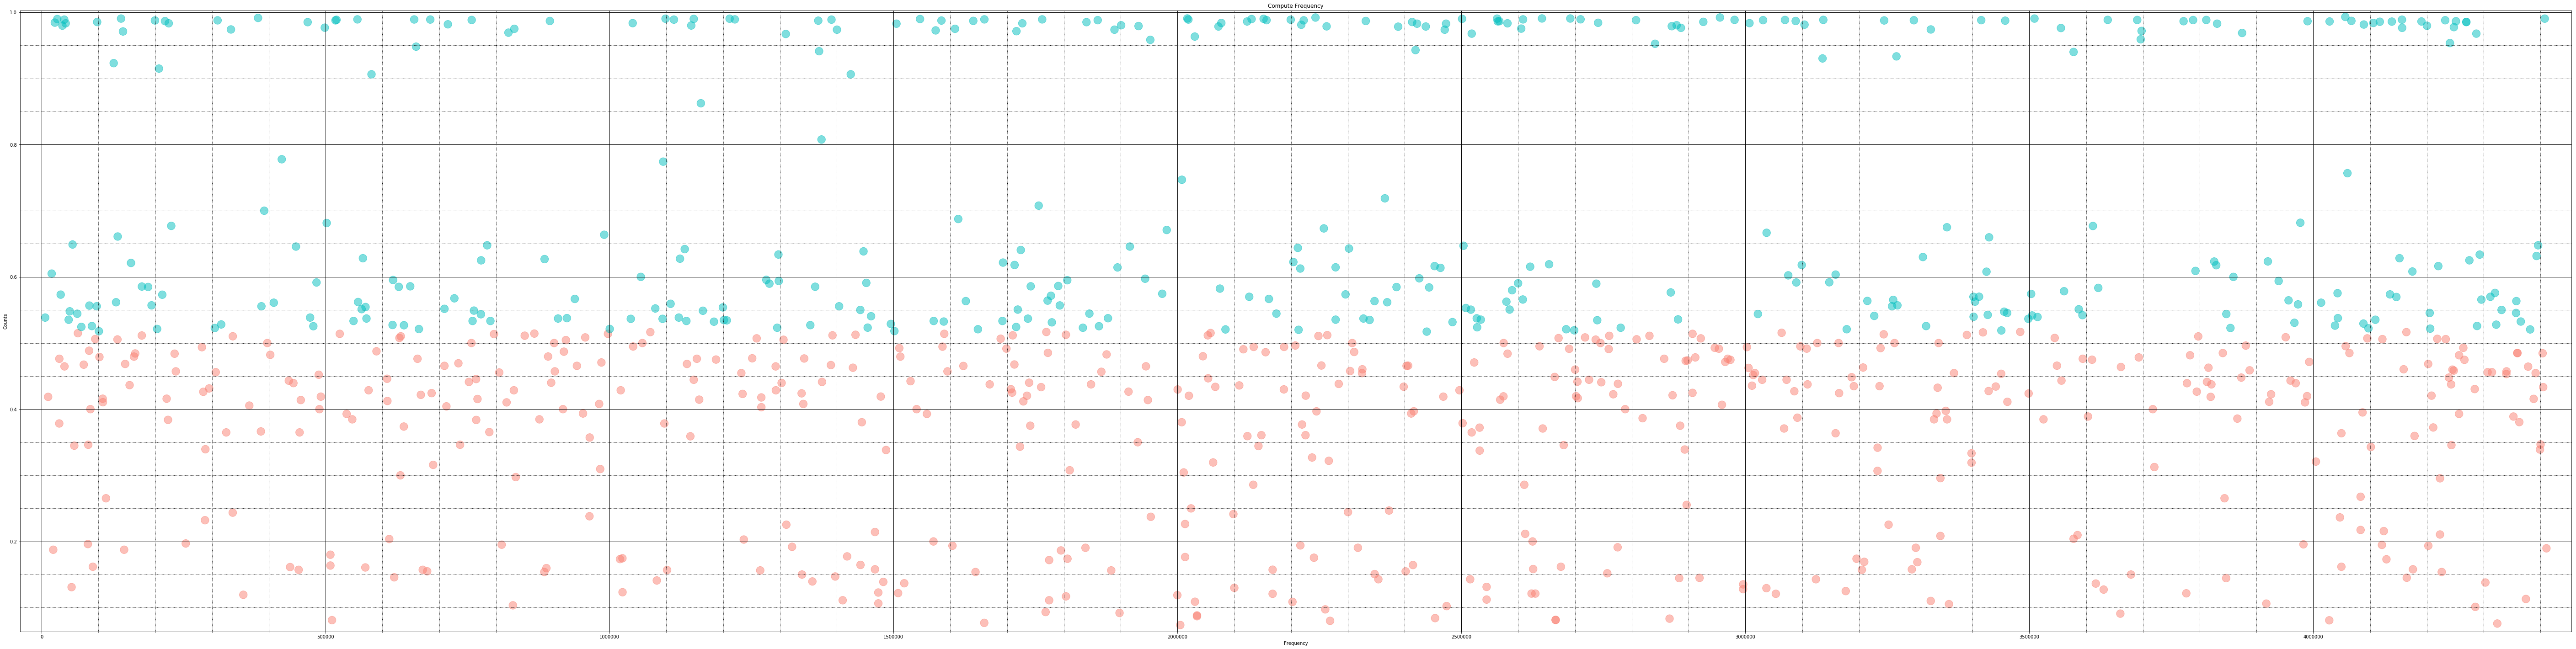

In [43]:
scatter_vcf_pos(PAIR190_dsf)

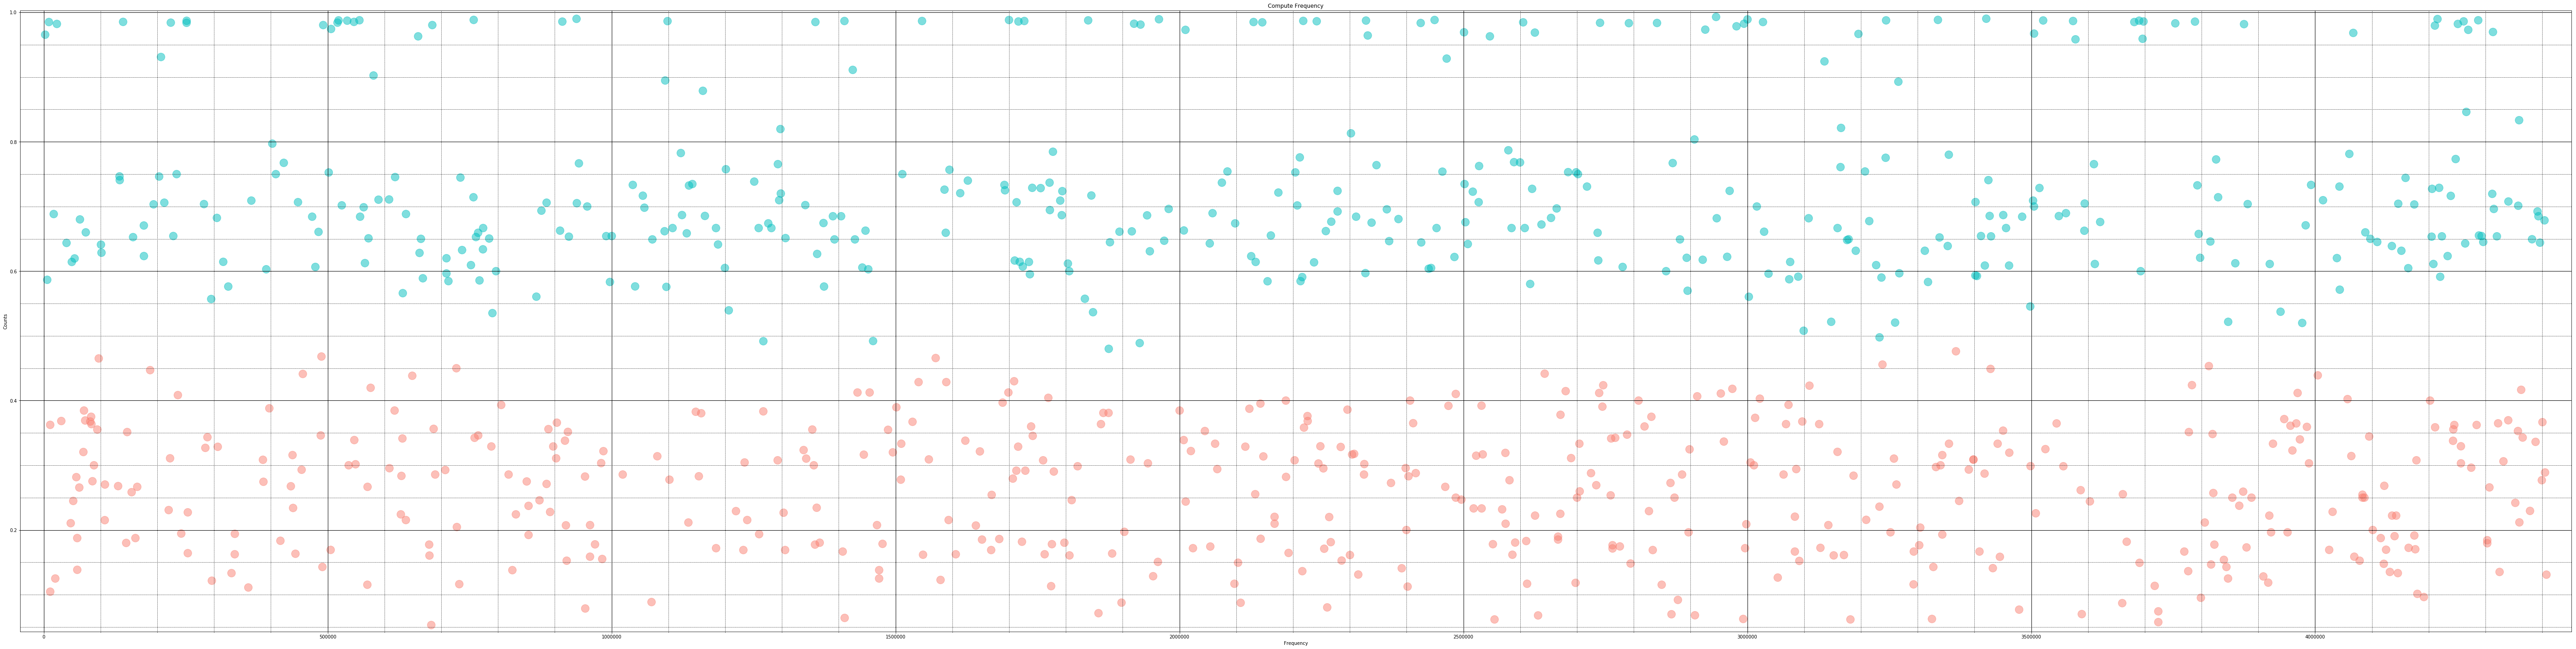

In [44]:
scatter_vcf_pos(PAIR180_dsf)

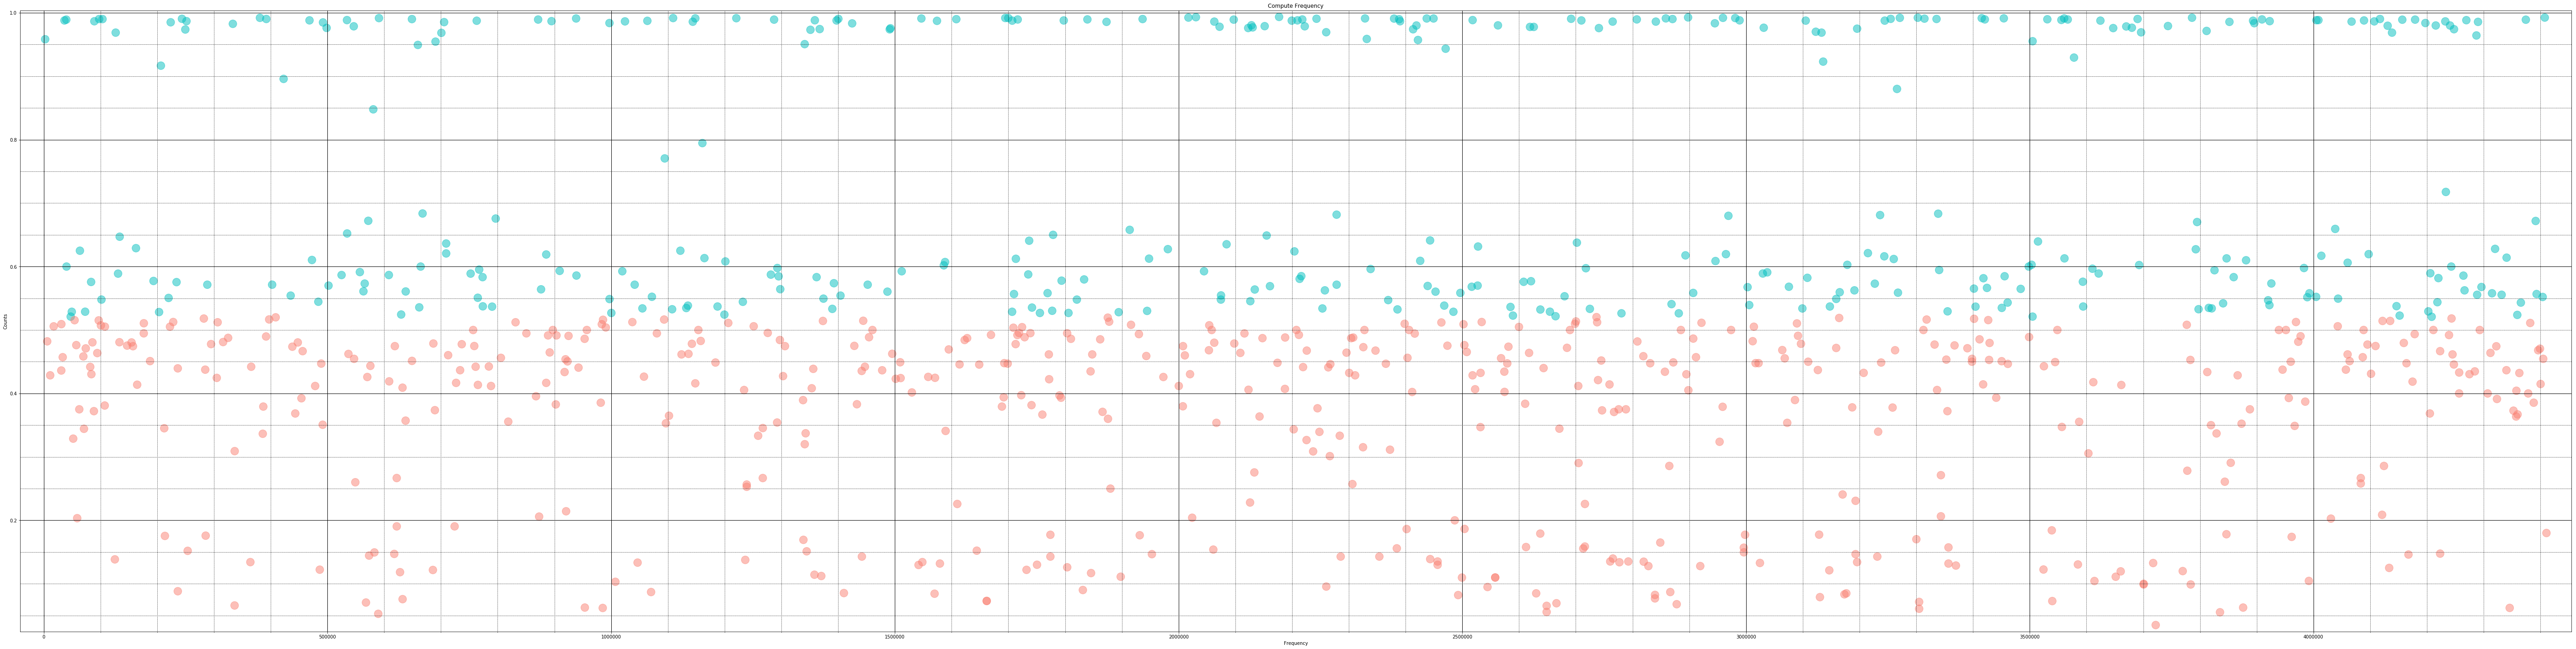

In [45]:
scatter_vcf_pos(PAIR150_dsf)

In [46]:
PAIR150_dsf['snp_right_distance'].dropna().describe()

count     1175.000000
mean      3607.334468
std       3608.008825
min          1.000000
25%       1128.000000
50%       2603.000000
75%       4933.000000
max      27856.000000
Name: snp_right_distance, dtype: float64

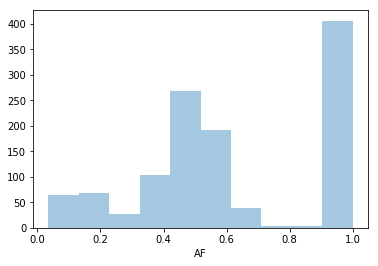

In [47]:
x = PAIR150_dsf['AF']
sns.distplot(x, kde=False, rug=False)

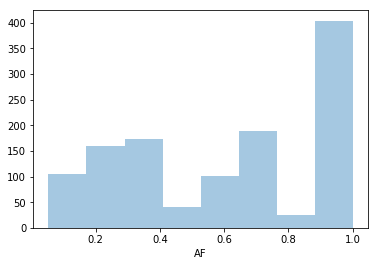

In [48]:
x = PAIR180_dsf['AF']
sns.distplot(x, kde=False, rug=False)

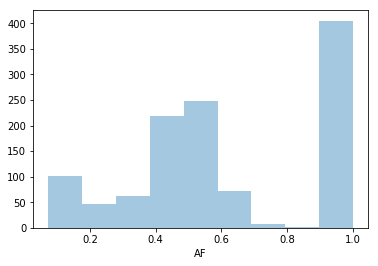

In [49]:
x = PAIR190_dsf['AF']
sns.distplot(x, kde=False, rug=False)

# Extract position by Allele Frequency

In [50]:
def split_df_mean(vcf_df):
    mean = vcf_df['AF'][vcf_df['AF'] < 1].mean(axis = 0)
    top_positions = vcf_df['POS'][(vcf_df['AF'] > mean) & (vcf_df['AF'] < 1)].tolist()
    bottom_positions = vcf_df['POS'][vcf_df['AF'] < mean].tolist()
    return top_positions, bottom_positions

# S = Somoza

In [51]:
S_file = "data/SOMOZACOL2_S11_L001__final.bam.snp.final"
S_final = import_to_pandas(S_file)
S_pos = set(S_final.loc[:,0].tolist())

In [52]:
top_P180, btm_P180 = split_df_mean(PAIR180_dsf)
top_P190, btm_P190 = split_df_mean(PAIR190_dsf)
top_P150, btm_P150 = split_df_mean(PAIR150_dsf)


In [53]:
print(len(top_P180))
print(len(btm_P180))
top_P180_set = set(top_P180)
btm_P180_set = set(btm_P180)

407
469


In [54]:
print(len(top_P190))
print(len(btm_P190))
top_P190_set = set(top_P190)
btm_P190_set = set(btm_P190)

388
516


In [55]:
print(len(top_P150))
print(len(btm_P150))
top_P150_set = set(top_P150)
btm_P150_set = set(btm_P150)

385
541


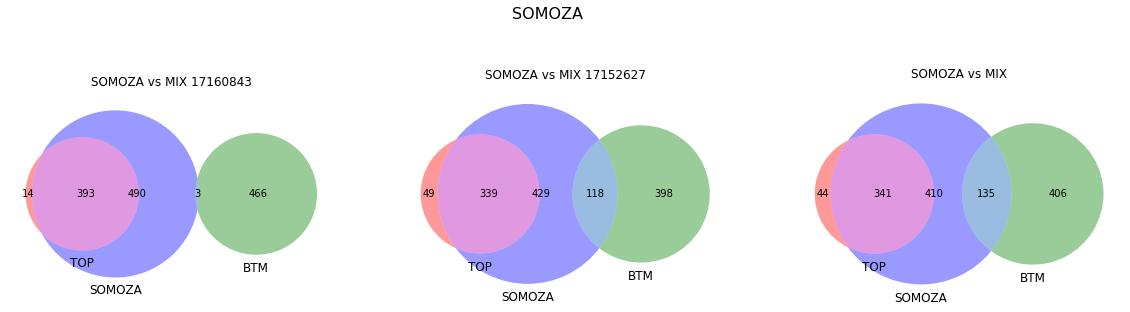

In [56]:
#Ven diagram with all (non exclusive snps in SOMOZA)
# P50 - 17171479
# P80 - 17160843
# P90 - 17152627

plt.figure(figsize=(20,5))

plt.subplot(1, 3, 1)
plt.title("SOMOZA vs MIX 17160843")
v3 = venn3([top_P180_set, btm_P180_set, S_pos], set_labels = ('TOP', 'BTM', 'SOMOZA'))

plt.subplot(1, 3, 2)
plt.title("SOMOZA vs MIX 17152627")
v = venn3([top_P190_set, btm_P190_set, S_pos], set_labels = ('TOP', 'BTM', 'SOMOZA'), )
#c = venn3_circles([top_P190_set, btm_P190_set, B_exclusive], linestyle='dashed', linewidth=1, color="grey")

plt.subplot(1, 3, 3)
plt.title("SOMOZA vs MIX")
v2 = venn3([top_P150_set, btm_P150_set, S_pos], set_labels = ('TOP', 'BTM', 'SOMOZA'))

plt.suptitle('SOMOZA', fontsize=16, verticalalignment='bottom')

plt.savefig(os.path.join('img', 'SOMOZA_ALL.svg'), format="svg")
#plt.show()

In [57]:
def split_df_mean_todict(vcf_df):
    mean = vcf_df['AF'][vcf_df['AF'] < 1].mean(axis = 0)
    top_positions = vcf_df[(vcf_df['AF'] > mean) & (vcf_df['AF'] < 1)]
    top_positions_dict = top_positions.set_index('POS')['ALT'].to_dict()
    bottom_positions = vcf_df[vcf_df['AF'] < mean]
    bottom_positions_dict = bottom_positions.set_index('POS')['ALT'].to_dict()
    return top_positions_dict, bottom_positions_dict

In [58]:
PAIR180_dsf.head()

#CHROM    POS ID REF ALT  QUAL FILTER  \
0  MTB_anc   2532  .   C   T   910   PASS   
1  MTB_anc   6140  .   G   T  1346   PASS   
2  MTB_anc   9143  .   C   T  2304   PASS   
3  MTB_anc  11370  .   C   T   778   PASS   
4  MTB_anc  11425  .   A   C    89   PASS   

                                     INFO    DP        AF    SB          DP4  \
0    DP=29;AF=0.965517;SB=0;DP4=0,0,17,11  29.0  0.965517   0.0    0,0,17,11   
1  DP=75;AF=0.586667;SB=0;DP4=17,14,22,22  75.0  0.586667   0.0  17,14,22,22   
2    DP=67;AF=0.985075;SB=3;DP4=0,1,39,27  67.0  0.985075   3.0    0,1,39,27   
3  DP=80;AF=0.362500;SB=3;DP4=23,28,16,13  80.0  0.362500   3.0  23,28,16,13   
4   DP=86;AF=0.104651;SB=34;DP4=48,29,0,9  86.0  0.104651  34.0    48,29,0,9   

   Fref  Rref  Fsample  Rsample  Is_repeat  snp_right_distance  \
0   0.0   0.0     17.0     11.0      False              3608.0   
1  17.0  14.0     22.0     22.0      False              3003.0   
2   0.0   1.0     39.0     27.0      False              2227.0   
3  23.0  28.0     16.0     13.0      False                55.0   
4  48.0  29.0      0.0      9.0      False              2035.0   

   snp_left_distance  
0                NaN  
1             3608.0  
2             3003.0  
3             2227.0  
4               55.0

In [59]:
PAIR180_dict = PAIR180_dsf.set_index('POS')['ALT'].to_dict()
PAIR190_dict = PAIR190_dsf.set_index('POS')['ALT'].to_dict()
PAIR150_dict = PAIR150_dsf.set_index('POS')['ALT'].to_dict()

In [60]:
get_lineage_coll(PAIR180_dict)
get_lineage_coll(PAIR190_dict)
get_lineage_coll(PAIR150_dict)

This samples belongs to linage 4
This samples belongs to linage 4
This samples belongs to linage 4


'4'

In [61]:
top_P180_dict, btm_P180_dict = split_df_mean_todict(PAIR180_dsf)
top_P190_dict, btm_P190_dict = split_df_mean_todict(PAIR190_dsf)
top_P150_dict, btm_P150_dict = split_df_mean_todict(PAIR150_dsf)

In [62]:
get_lineage_coll(top_P180_dict)
get_lineage_coll(top_P190_dict)
get_lineage_coll(top_P150_dict)
get_lineage_coll(btm_P180_dict)
get_lineage_coll(btm_P190_dict)
get_lineage_coll(btm_P150_dict)

This samples belongs to linage unknown
This samples belongs to linage unknown
This samples belongs to linage unknown
This samples belongs to linage unknown
This samples belongs to linage unknown
This samples belongs to linage unknown


'unknown'

In [63]:
get_resistance_snp(PAIR180_dict)
get_resistance_snp(PAIR190_dict)
get_resistance_snp(PAIR150_dict)

This strain has those resistance positions:rifampicin_(RMP)
This strain has those resistance positions:rifampicin_(RMP)
This strain has those resistance positions:rifampicin_(RMP)


['rifampicin_(RMP)']

In [64]:
get_resistance_snp(top_P180_dict)
get_resistance_snp(top_P190_dict)
get_resistance_snp(top_P150_dict)
get_resistance_snp(btm_P180_dict)
get_resistance_snp(btm_P190_dict)
get_resistance_snp(btm_P150_dict)

This strain has those resistance positions:rifampicin_(RMP)
This strain has those resistance positions:rifampicin_(RMP)
No resistance were found
No resistance were found
No resistance were found
This strain has those resistance positions:rifampicin_(RMP)


['rifampicin_(RMP)']